In [ ]:
from transformers import pipeline

bert_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=bert_ckpt)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
query = """Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in
Paris and I need a 15 passenger van"""
pipe(query)

[{'label': 'car_rental', 'score': 0.5490034222602844}]

In [ ]:
import torch
from pathlib import Path
import numpy as np


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.2 MB/s eta 0:00:00


In [ ]:
from evaluate import load

accuracy_score = load("accuracy")


In [ ]:
class PerformanceBenchmark:
  def __init__(self, pipeline, dataset, optim_type="BERT baseline"):
    self.pipeline = pipeline
    self.dataset = dataset
    self.optim_type = optim_type
  def compute_accuracy(self):
    preds, labels = [], []
    for example in self.dataset:
      pred = self.pipeline(example["text"])[0]["label"]
      label = example["intent"]
      preds.append(intents.str2int(pred))
      labels.append(label)
    accuracy = accuracy_score.compute(predictions=preds, references=labels)
    print(f"Accuracy on test set - {accuracy['accuracy']:.3f}")
    return accuracy
  def compute_size(self):
    state_dict = self.pipeline.model.state_dict()
    tmp_path = Path("model.pt")
    torch.save(state_dict, tmp_path)
    # Calculate size in megabytes
    size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
    # Delete temporary file
    tmp_path.unlink()
    print(f"Model size (MB) - {size_mb:.2f}")
    return {"size_mb": size_mb}
  def time_pipeline(self, query="What is the pin number for my account?"):
    latencies = []
    # Warmup
    for _ in range(10):
      _ = self.pipeline(query)
    # Timed run
    for _ in range(100):
      start_time = perf_counter()
      _ = self.pipeline(query)
      latency = perf_counter() - start_time
      latencies.append(latency)
    # Compute run statistics
    time_avg_ms = 1000 * np.mean(latencies)
    time_std_ms = 1000 * np.std(latencies)
    print(f"Average latency (ms) - {time_avg_ms:.2f} +/- {time_std_ms:.2f}")
    return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}
  def run_benchmark(self):
    metrics = {}
    metrics[self.optim_type] = self.compute_size()
    metrics[self.optim_type].update(self.time_pipeline())
    metrics[self.optim_type].update(self.compute_accuracy())
    return metrics

In [ ]:
from datasets import load_dataset
clinc = load_dataset("clinc_oos", "plus")

README.md: 0.00B [00:00, ?B/s]

plus/train-00000-of-00001.parquet:   0%|          | 0.00/312k [00:00<?, ?B/s]

plus/validation-00000-of-00001.parquet:   0%|          | 0.00/77.8k [00:00<?, ?B/s]

plus/test-00000-of-00001.parquet:   0%|          | 0.00/136k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/15250 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [ ]:
clinc

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 15250
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3100
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 5500
    })
})

In [ ]:
sample = clinc["test"][42]
sample

{'text': 'transfer $100 from my checking to saving account', 'intent': 133}

In [ ]:
intents = clinc["test"].features["intent"]
intents.int2str(sample["intent"])

'transfer'

In [ ]:
from time import perf_counter
for _ in range(3):
  start_time = perf_counter()
  _ = pipe(query)
  latency = perf_counter() - start_time
  print(f"Latency (ms) - {1000 * latency:.3f}")

Latency (ms) - 12.459
Latency (ms) - 8.501
Latency (ms) - 8.169


In [ ]:
pb = PerformanceBenchmark(pipe, clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 418.15


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Average latency (ms) - 21.45 +/- 12.32
Accuracy on test set - 0.867


In [ ]:
from transformers import TrainingArguments
class DistillationTrainingArguments(TrainingArguments):
  def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
    super().__init__(*args, **kwargs)
    self.alpha = alpha
    self.temperature = temperature

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from transformers import Trainer
class DistillationTrainer(Trainer):
  def __init__(self, *args, teacher_model=None, **kwargs):
    super().__init__(*args, **kwargs)
    self.teacher_model = teacher_model
  def compute_loss(self, model, inputs, return_outputs=False,num_items_in_batch=None):
    outputs_stu = model(**inputs)
    # Extract cross-entropy loss and logits from student
    loss_ce = outputs_stu.loss
    logits_stu = outputs_stu.logits
    # Extract logits from teacher
    with torch.no_grad():
      outputs_tea = self.teacher_model(**inputs)
      logits_tea = outputs_tea.logits
    # Soften probabilities and compute distillation loss
    loss_fct = nn.KLDivLoss(reduction="batchmean")
    loss_kd = self.args.temperature ** 2 * loss_fct(
      F.log_softmax(logits_stu / self.args.temperature, dim=-1),
      F.softmax(logits_tea / self.args.temperature, dim=-1))
    # Return weighted student loss
    loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
    return (loss, outputs_stu) if return_outputs else loss

In [ ]:
from transformers import AutoTokenizer
student_ckpt = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)
def tokenize_text(batch):
  return student_tokenizer(batch["text"], truncation=True)
clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
def compute_metrics(pred):
  predictions, labels = pred
  predictions = np.argmax(predictions, axis=1)
  return accuracy_score.compute(predictions=predictions, references=labels)

In [ ]:
batch_size = 48
finetuned_ckpt = "distilbert-base-uncased-finetuned-clinc"
student_training_args = DistillationTrainingArguments(
output_dir=finetuned_ckpt, eval_strategy = "epoch",
num_train_epochs=5, learning_rate=2e-5,
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size, alpha=1, weight_decay=0.01,
push_to_hub=True)

In [ ]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [ ]:
from transformers import AutoConfig
num_labels = intents.num_classes
student_config = (AutoConfig.from_pretrained(student_ckpt, num_labels=num_labels,
  id2label=id2label, label2id=label2id))

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def student_init():
  return (AutoModelForSequenceClassification.from_pretrained(student_ckpt, config=student_config).to(device))

In [ ]:
teacher_ckpt = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = (AutoModelForSequenceClassification
  .from_pretrained(teacher_ckpt, num_labels=num_labels)
  .to(device))
distilbert_trainer = DistillationTrainer(model_init=student_init,
  teacher_model=teacher_model, args=student_training_args,
  train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
  compute_metrics=compute_metrics, tokenizer=student_tokenizer)
distilbert_trainer.train()

/tmp/ipython-input-2575498506.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.339083,0.730968
2,3.833100,1.929619,0.844839
3,3.833100,1.202655,0.896452
4,1.751700,0.895604,0.911935
5,0.943900,0.806354,0.916452


TrainOutput(global_step=1590, training_loss=2.0980418607123994, metrics={'train_runtime': 322.5625, 'train_samples_per_second': 236.388, 'train_steps_per_second': 4.929, 'total_flos': 414689637990180.0, 'train_loss': 2.0980418607123994, 'epoch': 5.0})

In [ ]:
distilbert_trainer.push_to_hub("Training completed!")


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...d-clinc/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...518455.a39f5dc7d008.183.0: 100%|##########| 12.5kB / 12.5kB            

  ...d-clinc/model.safetensors:  13%|#2        | 33.5MB /  268MB            

  ...518737.a39f5dc7d008.183.1: 100%|##########| 15.1kB / 15.1kB            

CommitInfo(commit_url='https://huggingface.co/MikdadMrhij/distilbert-base-uncased-finetuned-clinc/commit/1545db042af4518ba36759dfdc21e5745787843a', commit_message='Training completed!', commit_description='', oid='1545db042af4518ba36759dfdc21e5745787843a', pr_url=None, repo_url=RepoUrl('https://huggingface.co/MikdadMrhij/distilbert-base-uncased-finetuned-clinc', endpoint='https://huggingface.co', repo_type='model', repo_id='MikdadMrhij/distilbert-base-uncased-finetuned-clinc'), pr_revision=None, pr_num=None)

In [ ]:
finetuned_ckpt = "MikdadMrhij/distilbert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

Device set to use cuda:0


In [ ]:
optim_type = "DistilBERT"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 255.88
Average latency (ms) - 4.31 +/- 0.38
Accuracy on test set - 0.855


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_metrics(perf_metrics, current_optim_type):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')
    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)
    legend = plt.legend(bbox_to_anchor=(1, 1))
    for handle in legend.legend_handles:
        handle.set_sizes([20])
    plt.ylim(80, 90)
    xlim = int(perf_metrics["BERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()


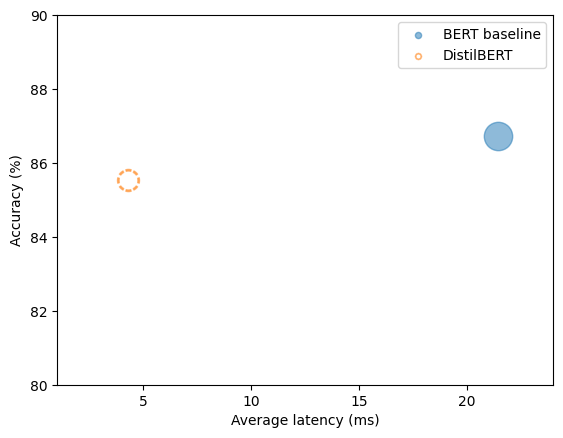

In [ ]:
plot_metrics(perf_metrics, optim_type)


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 13.5 MB/s eta 0:00:00


In [ ]:
def objective(trial):
  x = trial.suggest_float("x", -2, 2)
  y = trial.suggest_float("y", -2, 2)
  return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2

In [ ]:
import optuna
study = optuna.create_study()
study.optimize(objective, n_trials=1000)

[I 2025-10-03 19:23:12,801] A new study created in memory with name: no-name-100bc8c2-f323-49f7-a3b3-4ee3770ec767
[I 2025-10-03 19:23:12,806] Trial 0 finished with value: 207.51943506953913 and parameters: {'x': -0.42979464771990017, 'y': -1.2487169060268397}. Best is trial 0 with value: 207.51943506953913.
[I 2025-10-03 19:23:12,807] Trial 1 finished with value: 199.92710146495745 and parameters: {'x': 0.040617185311957904, 'y': -1.4090475402065348}. Best is trial 1 with value: 199.92710146495745.
[I 2025-10-03 19:23:12,809] Trial 2 finished with value: 1287.624766828806 and parameters: {'x': 1.5510228777641895, 'y': -1.1822538131232916}. Best is trial 1 with value: 199.92710146495745.
[I 2025-10-03 19:23:12,811] Trial 3 finished with value: 430.7281501431582 and parameters: {'x': -1.946096156925881, 'y': 1.7329079419695295}. Best is trial 1 with value: 199.92710146495745.
[I 2025-10-03 19:23:12,814] Trial 4 finished with value: 19.166985952363866 and parameters: {'x': 0.9410809100621

In [ ]:
study.best_params


{'x': 1.0110679891681715, 'y': 1.027465134174751}

In [ ]:
def hp_space(trial):
  return {"num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
  "alpha": trial.suggest_float("alpha", 0, 1),
  "temperature": trial.suggest_int("temperature", 2, 20)}

In [ ]:
best_run = distilbert_trainer.hyperparameter_search(n_trials=1, direction="maximize", hp_space=hp_space)

[I 2025-10-03 20:16:04,005] A new study created in memory with name: no-name-346ea654-9c6a-4f12-849a-09264b51c988
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁▆▇█████
eval/loss,█▄▂▂▁▁▁▁
eval/runtime,▁▁▂▁▁▁█▁
eval/samples_per_second,█▇▆█▇█▁▇
eval/steps_per_second,█▇▆█▇█▁▇
train/epoch,▁▂▂▃▃▄▅▅▆▆▇███
train/global_step,▁▂▂▃▃▄▅▅▆▆▇███
train/grad_norm,▇█▃▂▁
train/learning_rate,█▆▅▃▁
train/loss,█▃▂▁▁
eval/accuracy,0.91548


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.193593,0.580645
2,0.310500,0.095190,0.819032
3,0.310500,0.064745,0.880645
4,0.110500,0.050572,0.893871
5,0.072000,0.042386,0.905484
6,0.072000,0.037700,0.910645
7,0.058000,0.035510,0.912581
8,0.052200,0.034572,0.915484


It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
It seems you are trying to upload a large folder at once. This might take some time and then fail if the folder is too large. For such cases, it is recommended to upload in smaller batches or to use `HfApi().upload_large_folder(...)`/`hf upload-large-folder` instead. For more details, check out https://huggingface.co/docs/huggingface_hub/main/en/guides/upload#upload-a-large-folder.
[I 2025-10-03 20:29:54,206] Trial 0 finished with value: 0.915483870967742 and parameters: {'num_train_epochs': 8, 'alpha': 0.9882509450610403, 'temperature': 16}. Best is trial 0 with value: 0.915483870967742.


In [ ]:
print(best_run)

BestRun(run_id='0', objective=0.915483870967742, hyperparameters={'num_train_epochs': 8, 'alpha': 0.9882509450610403, 'temperature': 16}, run_summary=None)


In [ ]:
for k,v in best_run.hyperparameters.items():
  print(k,"    " , v)

num_train_epochs      10
alpha      0.12468168730193585
temperature      7


In [ ]:
for k,v in best_run.hyperparameters.items():
  setattr(student_training_args, k, v)
# Define a new repository to store our distilled model
distilled_ckpt = "distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = distilled_ckpt
# Create a new Trainer with optimal parameters
distil_trainer = DistillationTrainer(model_init=student_init,
  teacher_model=teacher_model, args=student_training_args,
  train_dataset=clinc_enc['train'], eval_dataset=clinc_enc['validation'],
  compute_metrics=compute_metrics, tokenizer=student_tokenizer)
distil_trainer.train();

/tmp/ipython-input-2575498506.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.575385,0.718065


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.575385,0.718065
2,0.759300,0.281207,0.884516
3,0.759300,0.179612,0.920645
4,0.277400,0.139597,0.932903
5,0.159600,0.120382,0.933548
6,0.159600,0.111007,0.937742
7,0.124500,0.106237,0.938710
8,0.109800,0.102268,0.940000
9,0.109800,0.100483,0.939355
10,0.103400,0.099606,0.939677


In [ ]:
distil_trainer.push_to_hub("Training complete")


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...d-clinc/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...d-clinc/model.safetensors:   6%|6         | 16.7MB /  268MB            

CommitInfo(commit_url='https://huggingface.co/MikdadMrhij/distilbert-base-uncased-distilled-clinc/commit/bee0846250ccdfb6ff0fcf1c63c51bd5cf829db7', commit_message='Training complete', commit_description='', oid='bee0846250ccdfb6ff0fcf1c63c51bd5cf829db7', pr_url=None, repo_url=RepoUrl('https://huggingface.co/MikdadMrhij/distilbert-base-uncased-distilled-clinc', endpoint='https://huggingface.co', repo_type='model', repo_id='MikdadMrhij/distilbert-base-uncased-distilled-clinc'), pr_revision=None, pr_num=None)

In [ ]:
istilled_ckpt = "MikdadMrhij/distilbert-base-uncased-distilled-clinc"
pipe = pipeline("text-classification", model=distilled_ckpt)
optim_type = "Distillation"
pb = PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
perf_metrics.update(pb.run_benchmark())

Device set to use cuda:0


Model size (MB) - 255.88
Average latency (ms) - 8.82 +/- 2.94
Accuracy on test set - 0.870


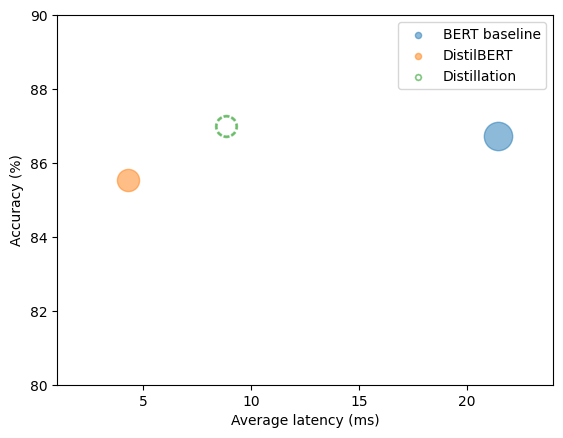

In [ ]:
plot_metrics(perf_metrics, optim_type)